# How to use [CausalImpact](https://google.github.io/CausalImpact/CausalImpact.html) with rpy2

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
# avoid collisions with rpy2 import of R's stats package
from scipy import stats as scipy_stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import ListVector

import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

from rpy2.robjects import pandas2ri
pandas2ri.activate()

## Install CausalImpact

Comment the cell below if already installed

In [4]:
# %%R
# install.packages(pkgs="Boom", quiet=FALSE, verbose=TRUE)
# install.packages(pkgs="CausalImpact", quiet=FALSE, verbose=TRUE)

## Load CausalImpact

In [5]:
causal = importr('CausalImpact')
causal

rpy2.robjects.packages.Package as a <module 'CausalImpact'>

## Dummy dataset parameters

In [6]:
n_obs = 100
pre_period = {'start': 0, 'end': 69}
post_period = {'start': 70,'end':  99}

# in R indices start at 1? either way that's whart CausalImpact expects
r_pre_period_start = pre_period['start'] + 1
r_pre_period_end = pre_period['end'] + 1

r_post_period_start = post_period['start'] + 1
r_post_period_end = post_period['end'] + 1

## CausalImpact R usage (using R magics)

In [7]:
# push our dummy data params to R
%Rpush n_obs
%Rpush r_pre_period_start
%Rpush r_pre_period_end
%Rpush r_post_period_start
%Rpush r_post_period_end

[1] 100
[1] 1
[1] 70
[1] 71
[1] 100
 [1] 130.6432 129.4597 129.4536 129.9282 132.9129 132.7616 130.1347 133.9869
 [9] 134.9480 131.3073
Posterior inference {CausalImpact}

                         Average        Cumulative  
Actual                   155            4665        
Prediction (s.d.)        146 (0.6)      4370 (18.1) 
95% CI                   [145, 147]     [4335, 4406]
                                                    
Absolute effect (s.d.)   9.8 (0.6)      294.6 (18.1)
95% CI                   [8.6, 11]      [259.0, 330]
                                                    
Relative effect (s.d.)   6.7% (0.41%)   6.7% (0.41%)
95% CI                   [5.9%, 7.5%]   [5.9%, 7.5%]

Posterior tail-area probability p:   0.001
Posterior prob. of a causal effect:  99.9%

For more details, type: summary(impact, "report")

              Actual      Pred Pred.lower Pred.upper    Pred.sd  AbsEffect
Average     155.4881  145.6681   144.5001   146.8533  0.6022255   9.820053
Cumulativ

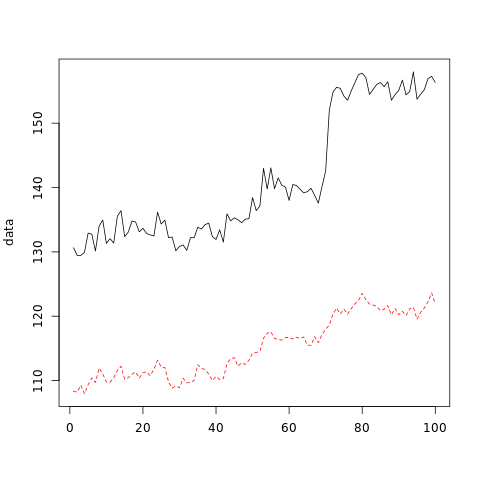

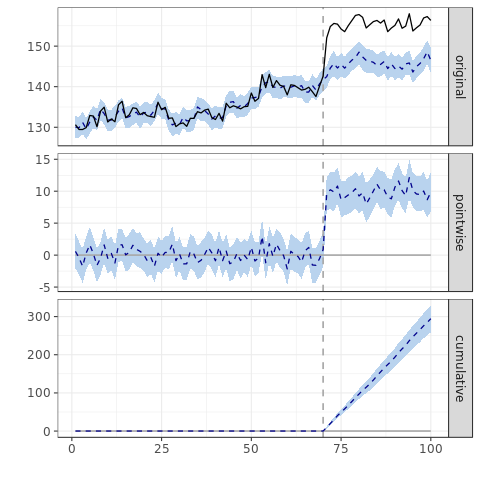

In [8]:
%%R
# generate fake data, run the model and plot results and print summary
print(n_obs)
print(r_pre_period_start)
print(r_pre_period_end)
print(r_post_period_start)
print(r_post_period_end)

# n_obs <- 100
# r_pre_period_start <- 1
# r_pre_period_end <- 70
# r_post_period_start <- 71
# r_post_period_end <- 100

set.seed(10)
x1 <- n_obs + arima.sim(model = list(ar = 0.999), n = n_obs)
y <- 1.2 * x1 + rnorm(n_obs)
y[r_post_period_start:n_obs] <- y[r_post_period_start:n_obs] + 10
data <- cbind(y, x1)
print(data[0:10])
write.csv(data, file = "causal_impact_toy_data.csv")
matplot(data, type = "l")
pre.period <- c(r_pre_period_start, r_pre_period_end)
post.period <- c(r_post_period_start, n_obs)
impact <- CausalImpact(data, pre.period, post.period)
summary(impact)
print(impact$summary)
plot(impact)


## CausalImpact using rpy2 with the same dataset generated by R above

Use the same file generated above to ensure consistency

In [9]:
df = pd.read_csv('causal_impact_toy_data.csv', index_col=False)
print(df.shape)
del df['Unnamed: 0']
df.head()

(100, 3)


,y,x1
0,130.643162,108.336849
1,129.459734,108.193738
2,129.453591,109.276980
3,129.928183,107.955425
4,132.912943,109.351117


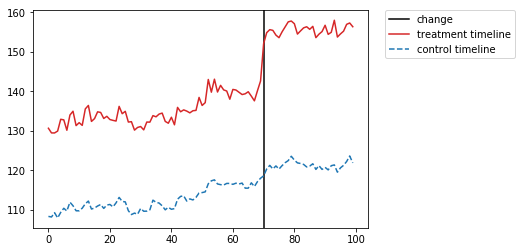

In [10]:
fig, ax = plt.subplots(1, 1)
ax.axvline(x=post_period['start'], label='change', color='black')
ax = plt.plot(df.index, df['y'], color='C3', label='treatment timeline')
ax = plt.plot(df.index, df['x1'], color='C0', label='control timeline', ls='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.0)

### Run model in rpy2

In [11]:
impact = causal.CausalImpact(
    data=df.values,
    pre_period=np.array([r_pre_period_start, r_pre_period_end]),
    post_period=np.array([r_post_period_start, r_post_period_end]),
    alpha=0.05)

impact = dict(zip(impact.names, list(impact)))
impact.keys()

dict_keys(['series', 'summary', 'report', 'model'])

### Summary

In [12]:
df_summary = pandas2ri.ri2py(impact['summary'])
print(df_summary.shape)
df_summary.transpose()

(2, 15)


,Average,Cumulative
Actual,155.488107,4664.643218
Pred,145.668054,4370.041630
Pred.lower,144.499493,4334.984790
Pred.upper,146.894265,4406.827964
Pred.sd,0.614348,18.430426
AbsEffect,9.820053,294.601588
AbsEffect.lower,8.593842,257.815254
AbsEffect.upper,10.988614,329.658428
AbsEffect.sd,0.614348,18.430426
RelEffect,0.067414,0.067414


## Compared with Python tcassou/causal_impact (TODO)

In [13]:
# pip install causal-impact
# https://github.com/tcassou/causal_impact

## Compared to Python jamalsenouci/causalimpact (TODO)

In [14]:
# pip install git+ssh://github.com/jamalsenouci/causalimpact.git
# https://github.com/jamalsenouci/causalimpact

## CausalImpact with rpy2 with fake data simulated using R's `arima.sim` (but no seed)

This doesn't produce the same dataset as the first one in this notebook as there doesn't seem to be a way to set the seed in rpy2.

In [15]:
arima_sim = importr('stats').arima_sim
arima_sim

R object with classes: ('function',) mapped to:
<DocumentedSTFunction - Python:0x7f6f1de4a348 / R:0x55d732402810>

### Generate control timeline

In [16]:
_x1 = arima_sim(model=ListVector({'ar': 0.999}),
                n=n_obs)
x1 = 100 + np.array(_x1)
x1

array([ 90.47820677,  91.03632185,  91.5009729 ,  92.13232791,
        92.43318728,  91.26895052,  92.53760666,  93.43321312,
        93.07844593,  93.63378799,  95.15631612,  96.41977311,
        96.51333924,  96.1872325 ,  96.95773269,  98.71690936,
        98.28081367,  98.80106644,  99.20417331,  97.84940735,
        97.91933176,  98.15723781, 100.13578608,  99.22729412,
        98.83926497,  98.97762599,  99.62346648,  99.63451072,
       100.3965656 ,  99.96820081, 100.151967  ,  99.34530944,
       101.08021485, 101.18456441, 100.87495262, 101.25699749,
       102.31107562, 103.51552097, 102.51420091, 102.97126159,
       104.99433971, 103.26228035, 104.07860082, 103.87694967,
       103.99592375, 103.04701706, 102.40213668, 101.94434661,
       101.62005571, 101.65017375, 102.62597687, 103.56879064,
       104.93324063, 104.03874971, 104.20998145, 104.07348083,
       103.80993867, 104.1597191 , 105.02589546, 105.5630912 ,
       105.24746863, 105.23952385, 106.39770591, 106.13

### Generate treatment timeline

In [17]:
# make the treatment timeline follow roughly the x1 timeline
y = 1.2 * x1 + scipy_stats.norm.rvs(size=100)

# add a random increase in post period normally centered around 10
y_post = y[post_period['start']:post_period['end']]
y_post += scipy_stats.norm.rvs(loc=10,
                               scale=3,
                               size=post_period['end'] - post_period['start'])
y

array([108.94926119, 110.42066365, 110.73174187, 110.48149044,
       110.1759849 , 107.72568827, 110.69261074, 113.47193235,
       112.16949782, 111.37550032, 114.96065179, 115.86307791,
       115.89816456, 115.19824101, 116.34700798, 119.21376106,
       118.36078776, 119.29550996, 119.40786397, 115.84486622,
       116.72514565, 119.49751897, 121.96953914, 119.62417394,
       118.73741641, 119.12587712, 118.88230407, 120.28249587,
       123.33080701, 119.09096347, 118.96627964, 119.8882881 ,
       121.21621124, 120.5332082 , 119.99287932, 121.81886012,
       121.84809549, 123.47168822, 124.46072608, 122.84582309,
       125.80491075, 124.07991132, 123.68399749, 124.62736352,
       123.82674693, 123.28735557, 122.53088397, 123.41730508,
       122.43116433, 121.58523744, 122.36732167, 123.75252677,
       125.81186949, 125.61632623, 126.14666785, 124.53270825,
       124.48820964, 124.322338  , 126.80784242, 125.8779114 ,
       127.27657984, 126.75931053, 125.99765419, 127.26

### Combine the two timelines

In [18]:
df = pd.DataFrame(data=np.vstack((y, x1)).T, columns=['y', 'x1'])
df.head()

,y,x1
0,108.949261,90.478207
1,110.420664,91.036322
2,110.731742,91.500973
3,110.481490,92.132328
4,110.175985,92.433187


### Plot the timelines

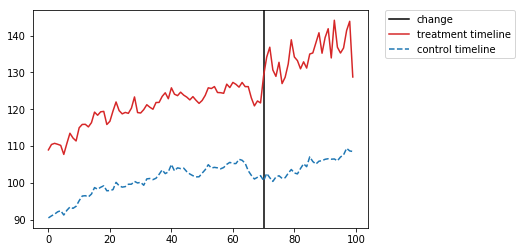

In [19]:
fig, ax = plt.subplots(1, 1)
ax.axvline(x=post_period['start'], label='change', color='black')
ax = plt.plot(df.index, df['y'], color='C3', label='treatment timeline')
ax = plt.plot(df.index, df['x1'], color='C0', label='control timeline', ls='dashed')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.0)

### Run model

In [20]:
impact = causal.CausalImpact(
    data=df.values,
    pre_period=np.array([r_pre_period_start, r_pre_period_end]),
    post_period=np.array([r_post_period_start, r_post_period_end]),
    model_args=ListVector({
        'niter': 500,  # MCMC samples
        'nseasons': 7   # 7 for daily observations
    }),
    alpha=0.05)

impact = dict(zip(impact.names, list(impact)))
impact.keys()

dict_keys(['series', 'summary', 'report', 'model'])

### Summary

In [21]:
df_summary = pandas2ri.ri2py(impact['summary'])
df_summary.transpose()

,Average,Cumulative
Actual,134.932359,4047.970765
Pred,125.558642,3766.759275
Pred.lower,124.472743,3734.182289
Pred.upper,126.451296,3793.538881
Pred.sd,0.513596,15.407888
AbsEffect,9.373716,281.211491
AbsEffect.lower,8.481063,254.431885
AbsEffect.upper,10.459616,313.788476
AbsEffect.sd,0.513596,15.407888
RelEffect,0.074656,0.074656


### Report

In [22]:
impact['report'][0]

'\n\nDuring the post-intervention period, the response variable had an average value of approx. 134.93. By contrast, in the absence of an intervention, we would have expected an average response of 125.56. The 95% interval of this counterfactual prediction is [124.47, 126.45]. Subtracting this prediction from the observed response yields an estimate of the causal effect the intervention had on the response variable. This effect is 9.37 with a 95% interval of [8.48, 10.46]. For a discussion of the significance of this effect, see below.\n\nSumming up the individual data points during the post-intervention period (which can only sometimes be meaningfully interpreted), the response variable had an overall value of 4.05K. By contrast, had the intervention not taken place, we would have expected a sum of 3.77K. The 95% interval of this prediction is [3.73K, 3.79K].\n\nThe above results are given in terms of absolute numbers. In relative terms, the response variable showed an increase of +7%

### Model

In [23]:
model = dict(zip(impact['model'].names, list(impact['model'])))
model.keys()

dict_keys(['pre.period', 'post.period', 'model.args', 'bsts.model', 'alpha'])

In [24]:
model_args = dict(zip(model['model.args'].names, list(model['model.args'])))
model_args.keys()
model_args = pd.DataFrame({k: [v[0]] for k, v in model_args.items()})
model_args

,dynamic.regression,niter,nseasons,prior.level.sd,season.duration,standardize.data
0,False,500,7,0.01,1.0,True


In [25]:
model['bsts.model']

R object with classes: ('bsts',) mapped to:
<ListVector - Python:0x7f6f1ddd0e08 / R:0x55d7344a63f0>
[Matrix, FloatVector, FloatVector, FloatVector, ..., FloatVector, ListVector, Formula, Matrix]
  coefficients: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f6f1dd21808 / R:0x55d735dfb460>
[0.000000, 0.000000, 0.000000, 0.000000, ..., 1.003902, 0.993193, 0.976822, 0.993464]
  sigma.obs: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f6f1ddef688 / R:0x55d735e47de0>
[0.310175, 0.311539, 0.338225, 0.321502, ..., 0.327533, 0.288530, 0.324340, 0.301387]
  sigma.level: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f6f1dd3a2c8 / R:0x55d735e48db0>
[0.010568, 0.010215, 0.010267, 0.010229, ..., 0.009234, 0.008037, 0.007877, 0.007392]
  sigma.seasonal.7: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f6f1ddd0f48 / R:0x55d734f27370>
[0.009707, 0.008203, 0.008454, 0.007876, ..., 0.018672, 0.020349, 0.021466, 0.024839]
...
  state.contributions: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('zoo',) mapped to:
<FloatVector - Python:0x7f6f1de45a48 / R:0x55d73387d830>
[-2.239328, -1.949187, -1.887846, -1.937192, ..., NA_real_, NA_real_, NA_real_, NA_real_]
R object with classes: ('bsts',) mapped to:
<ListVector - Python:0x7f6f1ddd0e08 / R:0x55d7344a63f0>
[Matrix, FloatVector, FloatVector, FloatVector, ..., FloatVector, ListVector, Formula, Matrix]
  log.likelihood: <class 'rpy2.robjects.Formula'>
  R object with classes: ('terms', 'formula') mapped to:
<Formula - Python:0x7f6f1de3ca48 / R:0x55d7335d3b30>
  has.regression: <class 'rpy2.robjects.vectors.Matrix'>
  R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x7f6f1de3c508 / R:0x55d735d7a1a0>
[1.000000, 1.000000, 1.000000, 1.000000, ..., 1.747956, 2.173030, 2.004022, 1.968672]

In [26]:
bsts_model = dict(zip(model['bsts.model'].names, list(model['bsts.model'])))
for k in sorted(list(bsts_model.keys())):
    print(k)

coefficients
family
final.state
has.regression
log.likelihood
model.options
niter
one.step.prediction.errors
original.series
predictors
prior
sigma.level
sigma.obs
sigma.seasonal.7
state.contributions
state.specification
terms
timestamp.info
xlevels


### Breakdown

In [27]:
data = np.array(impact['series'])
data.shape

(100, 14)

In [28]:
columns = np.array(list(impact['series'].names)[1])
columns

array(['response', 'cum.response', 'point.pred', 'point.pred.lower',
       'point.pred.upper', 'cum.pred', 'cum.pred.lower', 'cum.pred.upper',
       'point.effect', 'point.effect.lower', 'point.effect.upper',
       'cum.effect', 'cum.effect.lower', 'cum.effect.upper'], dtype='<U18')

In [29]:
# one row per observation
df_series = pd.DataFrame(data, columns=columns)
cols = df_series.columns
print(df_series.shape)
df_series.head(3)

(100, 14)


,response,cum.response,point.pred,point.pred.lower,point.pred.upper,cum.pred,cum.pred.lower,cum.pred.upper,point.effect,point.effect.lower,point.effect.upper,cum.effect,cum.effect.lower,cum.effect.upper
0,108.949261,108.949261,109.191474,105.764424,113.224244,108.949261,108.949261,108.949261,-0.242213,-4.274983,3.184837,0.0,0.0,0.0
1,110.420664,219.369925,109.438233,105.811874,112.602000,219.369925,219.369925,219.369925,0.982431,-2.181337,4.608790,0.0,0.0,0.0
2,110.731742,330.101667,109.987605,106.331734,113.435043,330.101667,330.101667,330.101667,0.744137,-2.703301,4.400008,0.0,0.0,0.0


### Matplotlib plot TODO

Use df_series to plot response and CI bands